In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [3]:
data = pd.read_csv('pulsar_data_train.csv')
data = data[:2000]
print('Dataset Shape : ', data.shape)

Dataset Shape :  (2000, 9)


In [4]:
print(data.isnull().sum())
data.head()

 Mean of the integrated profile                    0
 Standard deviation of the integrated profile      0
 Excess kurtosis of the integrated profile       253
 Skewness of the integrated profile                0
 Mean of the DM-SNR curve                          0
 Standard deviation of the DM-SNR curve          189
 Excess kurtosis of the DM-SNR curve               0
 Skewness of the DM-SNR curve                     95
target_class                                       0
dtype: int64


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


<AxesSubplot:>

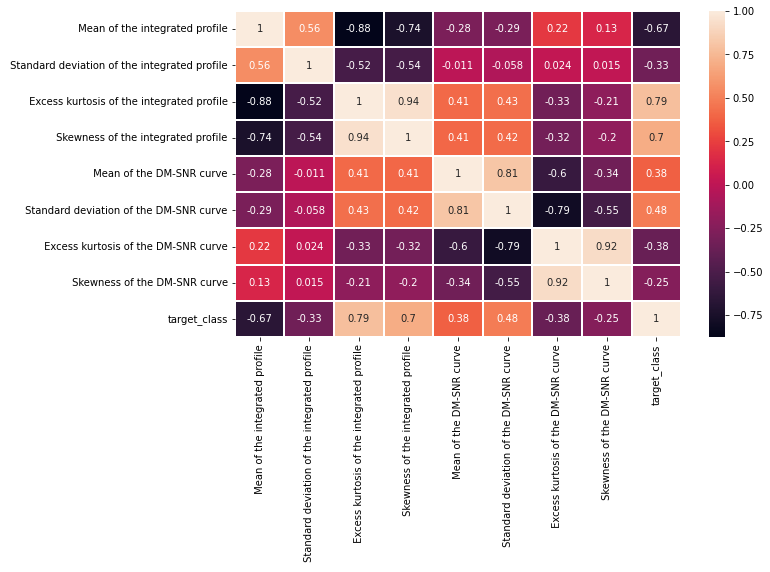

In [5]:
# visualizing the correlation matrix for Train data
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, linewidths=2, cbar=True, ax=ax)

In [6]:
# filling the NaN places in data set
data[' Excess kurtosis of the integrated profile'].fillna(data[' Excess kurtosis of the integrated profile'].mean(), inplace=True)
data[' Standard deviation of the DM-SNR curve'].fillna(data[' Standard deviation of the DM-SNR curve'].mean(), inplace=True)
data[' Skewness of the DM-SNR curve'].fillna(data[' Skewness of the DM-SNR curve'].mean(), inplace=True)

# spliting the dataset into independent columns and target column
x = data.iloc[:,:8]
y = data.iloc[:,8]

# Train-Test split
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)

# dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(xtrain)
xtrain = pca.transform(xtrain)
xtest = pca.transform(xtest)

# scaling the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [7]:
from sklearn.svm import SVC
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(xtrain, ytrain)
    classical_score = classical_svc.score(xtest, ytest)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.92
poly kernel classification test score:  0.92
rbf kernel classification test score:  0.93
sigmoid kernel classification test score:  0.87


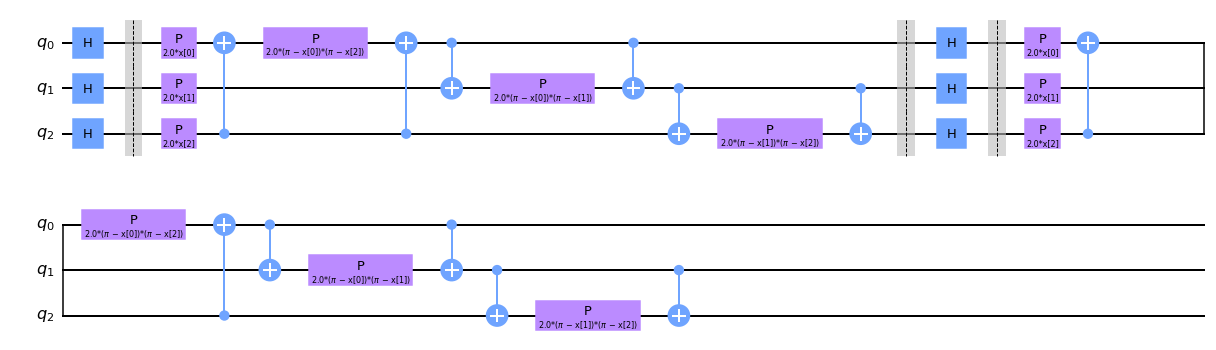

In [8]:
zz_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='circular', insert_barriers=True)
zz_map.decompose().draw()

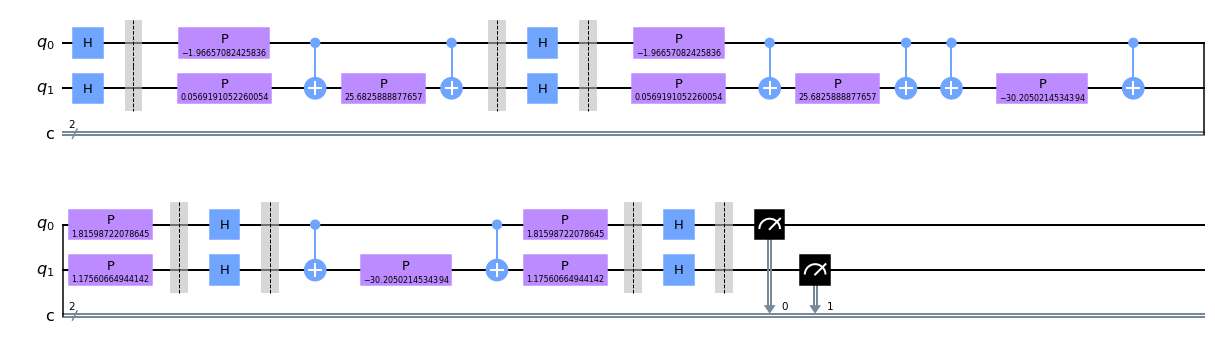

In [9]:
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

# Compute and evaluate Quantum Kernel Matrices.
matrix_train = zz_kernel.evaluate(x_vec=xtrain)
matrix_test = zz_kernel.evaluate(x_vec=xtest, y_vec=xtrain)

# example of ZZ kernel formation
zz_circuit = zz_kernel.construct_circuit(xtrain[0], xtrain[1])
zz_circuit.decompose().decompose().draw(output='mpl')

In [10]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, ytrain)
zzpc_score = zzpc_svc.score(matrix_test, ytest)
ypred = zzpc_svc.predict(matrix_test)
print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.91
